# Teste do modelo usando imagens radiográficas

## Importando as bibliotecas

- SYS: biblioteca focada na interação com o interpretador do python
- Pathlib: biblioteca para trabalhar com o sistema de arquivos usando POO
- TensorFlow: biblioteca para processamento de dados e contrução de CNN
- Keras: API de deep learining de alto nível executada sobre o TensorFlow
- Numpy: biblioteca para computação científica com arrays e matrizes multidimensionais
- SciKit Learn: biblioteca para ML com ferramentas para análise preditiva de dados 
- JSON: biblioteca para codificação e decodificação de no formatpo JavaScript Object Notation
- Matplot: biblioteca de para geração de imagens gráficas

In [1]:
import sys
import pathlib
import tensorflow as tf
import keras
import numpy as np
import sklearn
import json
import matplotlib.pyplot as plt

## Definindo a localização dos dados

Verifica se o código está sendo rodado no Google Colab e, se sim, monta o drive no ambiente de execução e aponta a pasta raiz do projeto

In [2]:
if "google.colab" in sys.modules:
    from google.colab import drive

    drive.mount("/content/drive")
    BASE_PATH = pathlib.Path("/content/drive/MyDrive/classification-of-medical-images-using-cnn/").resolve()
else:
    BASE_PATH = pathlib.Path().resolve().parents[1]

Mounted at /content/drive


- Armazena o local onde os dados de teste estão presentes
- Armazena o local onde o modelo já treinado está salvo
- Armazena o local onde as métricas apuradas pelo teste ficarão salvas

In [3]:
TEST_DIR = BASE_PATH / "data" / "test"
MODEL_PATH = BASE_PATH / "models" / "xray_images.keras"
METRICS_PATH = BASE_PATH / "results" / "metrics.json"

METRICS_PATH.parent.mkdir(parents=True, exist_ok=True)

## Carregamento do dataset

- Carrega as imagens de teste:
  - `image_size`: redimensiona as imagens
  - `batch_size`: define o número de imagens por lote
  - `label_mode`: separa todas as imagens em duas classes
  - `shuffle`: define que as imagens não serão embaralhadas

- Em seguida aplica normalização dos pixels e otimiza o desemepnho usando AUTOTUNE

In [4]:
test_data = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(224, 224),
    batch_size=32,
    label_mode="binary",
    shuffle=False,
)

normalization_layer = tf.keras.layers.Rescaling(1.0 / 255)

test_data = test_data.map(lambda x, y: (normalization_layer(x), y))

test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 624 files belonging to 2 classes.


## Teste do modelo

- Carrega o modelo do disco
- Realiza o teste do modelo e salva as métricas do teste

In [5]:
model = keras.models.load_model(MODEL_PATH)

metrics = model.evaluate(test_data, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - AUC: 0.5882 - accuracy: 0.6451 - loss: 0.7070


## Coleta das Previsões do Modelo

- O loop `for` percorre todo o conjunto de teste em lotes (batches)
  - A função `predict` colhe o palpite do modelo em relação às imagens com um número variando de 0 a 1 que quanto mais próximo de 0, mais o modelo acredita se tratar da classe 0, quanto mais próximo 1, da classe 1
  - Armazena as classes das imagens (0 ou 1) em `y_true`, transformando os tensores em arrays
  - Armazena os palpites do modelo em `y_scores` 
  - A função `flatten` é usada para transformar matrizes multidimensionais em arrays unidimensionais
- A função `np.array` transforma os dados em arrays do numpy
- `y_pred` usa os palpites do modelo para definir as classes 0 ou 1:
  - Se o palpite for maior que `0.5`, vira 1
  - Se for menor ou igual a `0.5`, vira 0

In [6]:
y_true = []
y_scores = []

for images, labels in test_data:
    predictions = model.predict(images)
    y_true.extend(labels.numpy().flatten())
    y_scores.extend(predictions.flatten())

y_true = np.array(y_true)
y_scores = np.array(y_scores)

y_pred = (y_scores > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


## Cálculo de métricas que dependem da "decisão" do modelo

- Estas métricas dependem das decisões do modelo (`y_pred`) entre uma das classes binárias, i.e., qual classe o modelo previu

- A matriz de consusão é calculada pela biblioteca do SciKit e a partir dela são revelados os seguintes dados:
  - Verdadeiros Negativos (TN): quantos casos negativos (classe 0) o modelo previu corretamente
  - Falsos Positivos (FP): quantos casos negativos o modelo previu de forma errada
  - Falsos Negativos (FN): quantos casos positivos (classe 1) o modelo previu de forma errada
  - Verdadeiros Positivos (TP): quantos casos positivos o modelo previu corretamente

In [7]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

TN, FP, FN, TP = confusion_matrix.ravel().tolist()

metrics["confusion_matrix"] = {
    "TN": int(TN),
    "FP": int(FP),
    "FN": int(FN),
    "TP": int(TP),
}

print(metrics["confusion_matrix"])

{'TN': 131, 'FP': 103, 'FN': 34, 'TP': 356}


#### Visualização da Matriz de Confusão

- `plt.subplots`: define uma figura (`fig`) e todos os eixos (`ax`) e define seu tamanho na tela
- `ConfusionMatrixDisplay`: classe de SciKit-Learen usada para visualizar uma matriz de consusão de forma gráfica usando Matplotlib
- `ConfusionMatrixDisplay().plot`: mostra a matriz de confusão com os valores fornecidos
- `ax.set_xlabel`: mostra o título do eixo horizontal
- `ax.set_ylabel`: mostra o título do eixo vertical
- `ax.set_tile`: mostra o título do gráfico
- `plt.show`: mostra o gráfico na tela

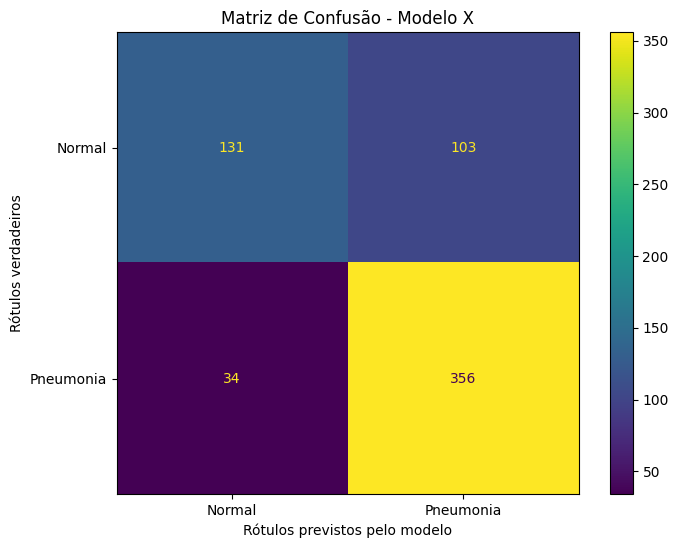

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Normal', 'Pneumonia'])
disp.plot(ax=ax)

ax.set_xlabel("Rótulos previstos pelo modelo")
ax.set_ylabel("Rótulos verdadeiros")
ax.set_title("Matriz de Confusão - Modelo X")

plt.show()

- A "precision" mede: do total de previsões positivas (classe 1) quantas realmente eram positivas

  $$ Precisão = \frac{Verdadeiros \, Positivos}{Verdadeiros \, Positivos + Falsos \, Positivos} $$

- A "sensibility" ou "recall" mede: do total de casos positivos, quantos o modelo conseguiu identificar corretamente

  $$ Sensibilidade = \frac{Verdadeiros \, Positivos}{Verdadeiros \, Positivos + Falsos \, Negativos} $$

- O score F1 é basicamente a média harmônica entre a precisão e a sensibilidade, que acaba privilegiando o valor mais baixo entre elas

  $$ F1 = 2 * \frac{Precisão * Sensibilidade}{Precisão + Sensibilidade} $$

- A "specificity" mede: do total de casos negativos (classe 0), quantos o modelo conseguiu identificar corretamente

  $$ Especificidade = \frac{Verdadeiros \, Negativos}{Verdadeiros \, Negativos + Falsos \, Positivos} $$


In [9]:
metrics["precision"] =  TP / (TP + FP) if (TP + FP) else 0
metrics["sensibility"] = TP / (TP + FN)
metrics["f1_score"] = sklearn.metrics.f1_score(y_true, y_pred)
metrics["specificity"] = TN / (TN + FP)

## Cálculo de métricas que dependem do "nível de confiança" do modelo

- Estas métricas dependem das probabilidades atribuídas pelo modelo (`y_scores`) entre as classes binárias, i.e., quão próximo de uma decisão ele está
- `fpr`: representa a taxa de falsos positivos, isto é a proporção do número de casos negativos (classe 0) que o modelo classificou como positivo (classe 1)

  $$ FPR = \frac{Falsos \, Positivos}{Verdadeiros \, Positivos + Falsos \, Negativos} $$

- `tpr`: representa a taxa de verdadeiros positivos, isto é a proporção do número de casos positivos que o modelo classificou como positivo

  $$ TPR = \frac{Verdadeiros \, Positivos}{Verdadeiros \, Positivos + Falsos \, Negativos} $$

- `thresholds`: são os limiares de corte definidos pelo modelo em cada ponto

- `roc_auc`: é a área sob a curva formada, quanto mais próxima de 1, mais exato é o modelo


In [10]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_scores)
roc_auc = sklearn.metrics.roc_auc_score(y_true, y_scores)

metrics["roc_auc"] = float(roc_auc)

#### Visualização da curva ROC

- `plt.subplots`: define uma figura (`fig`) e todos os eixos (`ax`) e define seu tamanho na tela
- `RocCurveDisplay`: classe de SciKit-Learen usada para visualizar a curva ROC de forma gráfica usando Matplotlib
- `RocCurveDisplay().plot`: mostra uma linha com os valores fornecidos
- `ax.plot`: mostra uma linha que liga os pontos fornecidos no estilo tracejada, cor laranja e legenda própria
- `ax.set_xlabel`: mostra o título do eixo horizontal
- `ax.set_ylabel`: mostra o título do eixo vertical
- `ax.set_tile`: mostra o título do gráfico
- `ax.legend`:  mostra a legenda das linhas do gráfico
- `plt.show`: mostra o gráfico na tela

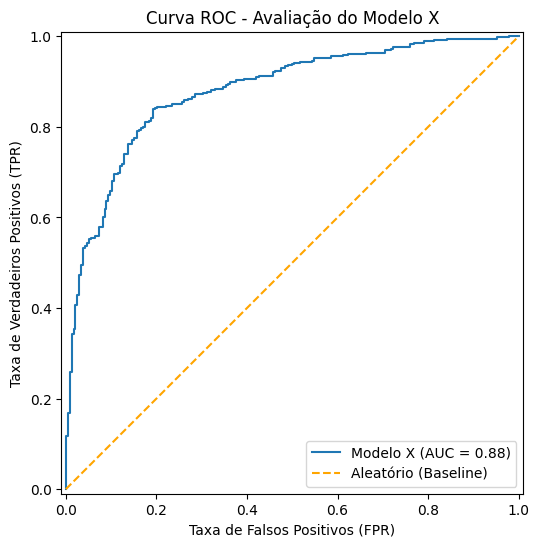

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))

disp = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Modelo X')
disp.plot(ax=ax) 

ax.plot([0, 1], [0, 1], color="orange", linestyle="--", label="Aleatório (Baseline)")
ax.set_xlabel("Taxa de Falsos Positivos (FPR)")
ax.set_ylabel("Taxa de Verdadeiros Positivos (TPR)")
ax.set_title("Curva ROC - Avaliação do Modelo X")
ax.legend()

plt.show()

## Salvamento das métricas de avaliação

Salva as métricas de avaliação em disco no formato JSON

In [13]:
with open(METRICS_PATH, "w") as f:
    json.dump(metrics, f, indent=4)

print(json.dumps(metrics, indent=4))

{
    "AUC": 0.8788461089134216,
    "accuracy": 0.7804487347602844,
    "loss": 0.4572164714336395,
    "confusion_matrix": {
        "TN": 131,
        "FP": 103,
        "FN": 34,
        "TP": 356
    },
    "precision": 0.775599128540305,
    "sensibility": 0.9128205128205128,
    "f1_score": 0.8386336866902238,
    "specificity": 0.5598290598290598,
    "roc_auc": 0.8789502520271751
}
